In [86]:
# ============================================================================
# SECTION 1: SETUP & INSTALLATION
# ============================================================================
print("Installing required packages...")
!pip install -q tensorflow matplotlib seaborn scikit-learn

Installing required packages...


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Nadam
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import cv2
import os
import time
from pathlib import Path

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [88]:
# ============================================================================
# SECTION 2: DOWNLOAD & LOAD DATASET (AUTO)
# ============================================================================
print("\n" + "="*70)
print("LOADING DATASET (Auto-Download)")
print("="*70)

# Load beans dataset from TensorFlow Datasets
print("Downloading beans dataset... (this may take a few minutes)")
(ds_train, ds_val, ds_test), ds_info = tfds.load('beans', split=['train', 'validation', 'test'], with_info=True, as_supervised=True)

# Display dataset information
print("\n✅ Dataset loaded successfully!")
print(f"Dataset: {ds_info.name}")
print(f"Description: {ds_info.description}")
print(f"\nClasses: {ds_info.features['label'].names}")
print(f"  - angular_leaf_spot: class 0")
print(f"  - bean_rust: class 1")
print(f"  - healthy: class 2")

print(f"\nDataset splits:")
print(f"  Training samples: {ds_info.splits['train'].num_examples}")
print(f"  Validation samples: {ds_info.splits['validation'].num_examples}")
print(f"  Test samples: {ds_info.splits['test'].num_examples}")
print(f"  Total: {sum([s.num_examples for s in ds_info.splits.values()])}")


LOADING DATASET (Auto-Download)

✅ Dataset loaded successfully!
Dataset: beans
Description: Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
and collected by the Makerere AI research lab.

Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']
  - angular_leaf_spot: class 0
  - bean_rust: class 1
  - healthy: class 2

Dataset splits:
  Training samples: 1034
  Validation samples: 133
  Test samples: 128
  Total: 1295


In [89]:
# ============================================================================
# SECTION 3: CONFIGURATION
# ============================================================================
print("\n" + "="*70)
print("CONFIGURATION")
print("="*70)

CONFIG = {
    'image_size': (128, 128),
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 100,
    'num_classes': 3,
    'optimizer': 'adam',
    'seed': 42,

    # Improvements
    'l2_reg': 0.0001,  # Weight decay
    'dropout_rate': 0.3,  # Moderate dropout
    'use_enhanced_augmentation': True,

     # NEW: CLAHE Configuration
    'use_clahe': False,  # Enable CLAHE preprocessing
    'clahe_clip_limit': 2.0,
    'clahe_tile_size': (8, 8),
}

print("\nConfiguration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# Set seeds
np.random.seed(CONFIG['seed'])
tf.random.set_seed(CONFIG['seed'])

# Class names
class_names = ds_info.features['label'].names



CONFIGURATION

Configuration:
  image_size: (128, 128)
  batch_size: 32
  learning_rate: 0.001
  epochs: 100
  num_classes: 3
  optimizer: adam
  seed: 42
  l2_reg: 0.0001
  dropout_rate: 0.3
  use_enhanced_augmentation: True
  use_clahe: False
  clahe_clip_limit: 2.0
  clahe_tile_size: (8, 8)


In [90]:
# ============================================================================
# SECTION 3.5: CLAHE PREPROCESSING (NEW)
# ============================================================================
print("\n" + "="*70)
print("CLAHE PREPROCESSING")
print("="*70)

def apply_clahe(image_np):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    to enhance image contrast and details

    Args:
        image_np: RGB image as numpy array (0-255)

    Returns:
        Enhanced RGB image
    """
    # Convert RGB to LAB color space
    lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)

    # Split LAB channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L channel (lightness)
    clahe = cv2.createCLAHE(
        clipLimit=CONFIG['clahe_clip_limit'],
        tileGridSize=CONFIG['clahe_tile_size']
    )
    l_clahe = clahe.apply(l)

    # Merge channels back
    lab_clahe = cv2.merge([l_clahe, a, b])

    # Convert back to RGB
    rgb_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    return rgb_clahe

print("✅ CLAHE configured:")
print(f"  Clip Limit: {CONFIG['clahe_clip_limit']}")
print(f"  Tile Grid Size: {CONFIG['clahe_tile_size']}")
print(f"  Enabled: {CONFIG['use_clahe']}")


CLAHE PREPROCESSING
✅ CLAHE configured:
  Clip Limit: 2.0
  Tile Grid Size: (8, 8)
  Enabled: False


In [91]:
# ============================================================================
# SECTION 4: DATA PREPROCESSING & AUGMENTASI
# ============================================================================
print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

def preprocess_image(image, label):
    """Basic preprocessing"""
    image = tf.image.resize(image, CONFIG['image_size'])

    # Apply CLAHE if enabled
    if CONFIG['use_clahe']:
        def clahe_wrapper(img):
            # Convert to uint8 for OpenCV
            img_uint8 = img.numpy().astype(np.uint8)
            # Apply CLAHE
            enhanced = apply_clahe(img_uint8)
            return enhanced.astype(np.float32)

        image = tf.py_function(clahe_wrapper, [image], tf.float32)
        image.set_shape([*CONFIG['image_size'], 3])

    # Normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


def enhanced_augmentation(image, label):
    """
    Enhanced augmentation to match paper performance
    Based on: Elfatimi et al. (2022) methodology
    """
    if not CONFIG['use_enhanced_augmentation']:
        return image, label

    # Random horizontal flip (50% chance)
    image = tf.image.random_flip_left_right(image)

    # Random vertical flip (30% chance)
    if tf.random.uniform([]) > 0.7:
        image = tf.image.random_flip_up_down(image)

    # Random rotation (0, 90, 180, 270 degrees)
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k)

    # Random brightness (±15%)
    image = tf.image.random_brightness(image, 0.15)

    # Random contrast (±20%)
    image = tf.image.random_contrast(image, 0.8, 1.2)

    # Random saturation (±15%)
    image = tf.image.random_saturation(image, 0.85, 1.15)

    # Random hue (±5%)
    image = tf.image.random_hue(image, 0.05)

    # Random zoom via crop (5-10% zoom)
    if tf.random.uniform([]) > 0.5:
        # Calculate crop size (90-95% of original)
        crop_fraction = tf.random.uniform([], 0.9, 0.95)
        h, w = CONFIG['image_size']
        crop_h = tf.cast(h * crop_fraction, tf.int32)
        crop_w = tf.cast(w * crop_fraction, tf.int32)

        # Random crop and resize back
        image = tf.image.random_crop(image, [crop_h, crop_w, 3])
        image = tf.image.resize(image, CONFIG['image_size'])

    # Clip values to valid range
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

print("✅ Enhanced augmentation configured:")
print("  - Horizontal & vertical flip")
print("  - Random rotation (90° increments)")
print("  - Brightness, contrast, saturation, hue adjustment")
print("  - Random zoom (crop & resize)")



DATA PREPROCESSING
✅ Enhanced augmentation configured:
  - Horizontal & vertical flip
  - Random rotation (90° increments)
  - Brightness, contrast, saturation, hue adjustment
  - Random zoom (crop & resize)


In [92]:
# ============================================================================
# SECTION 5: BUILD DATA PIPELINE (FIXED ORDER!)
# ============================================================================
print("\n" + "="*70)
print("BUILDING DATA PIPELINE (OPTIMIZED)")
print("="*70)

# TRAINING PIPELINE (CORRECT ORDER)
train_ds = ds_train.map(
    preprocess_image,
    num_parallel_calls=tf.data.AUTOTUNE
)

# Cache BEFORE augmentation (so augmentation is random each epoch)
train_ds = train_ds.cache()
# train_ds = train_ds.cache('./cache/train')  # ✅ Disk cache preprocessed images

# Apply augmentation AFTER cache
train_ds = train_ds.map(
    enhanced_augmentation,
    num_parallel_calls=tf.data.AUTOTUNE
)

# Shuffle, batch, prefetch
train_ds = train_ds.shuffle(1000, seed=CONFIG['seed'])
train_ds = train_ds.batch(CONFIG['batch_size'])
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# VALIDATION PIPELINE (No augmentation)
val_ds = ds_val.map(
    preprocess_image,
    num_parallel_calls=tf.data.AUTOTUNE
)
val_ds = val_ds.cache() # ✅ Cache validation (no augmentation)
val_ds = val_ds.batch(CONFIG['batch_size'])
# val_ds = val_ds.cache()
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# TEST PIPELINE
test_ds = ds_test.map(
    preprocess_image,
    num_parallel_calls=tf.data.AUTOTUNE
)
test_ds = test_ds.cache()  # ✅ Add cache for test set
test_ds = test_ds.batch(CONFIG['batch_size'])
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

print("✅ Data pipeline ready")
print(f"  Training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"  Validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"  Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")


BUILDING DATA PIPELINE (OPTIMIZED)
✅ Data pipeline ready
  Training batches: 33
  Validation batches: 5
  Test batches: 4



SAMPLE VISUALIZATION
Plotting training samples...


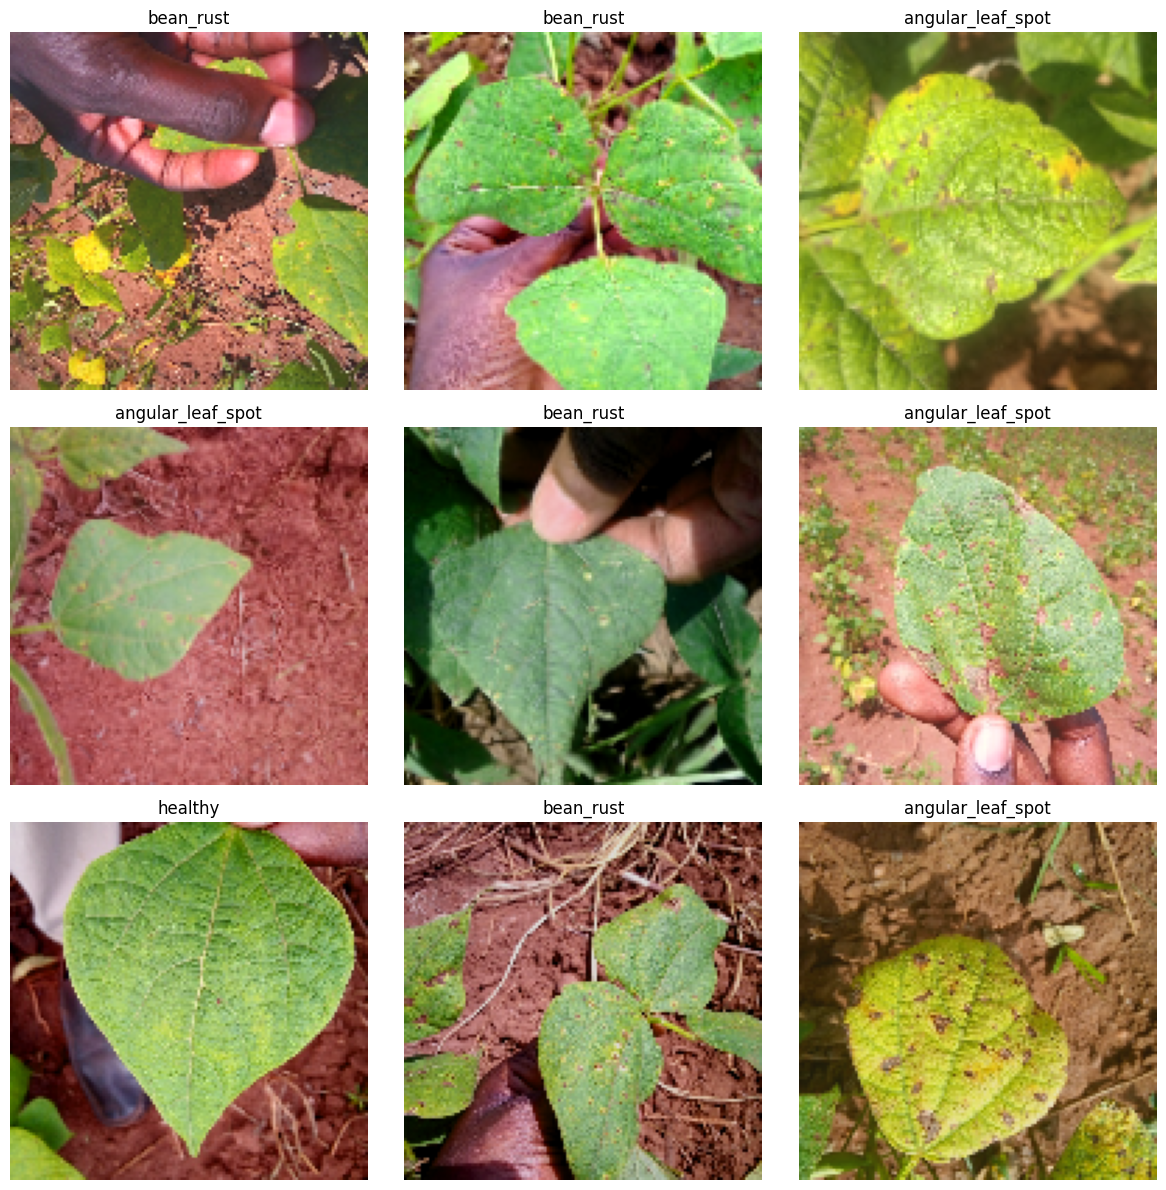

CLAHE is disabled, skipping comparison


In [93]:
# ============================================================================
# SECTION 5: VISUALIZE SAMPLES
# ============================================================================
print("\n" + "="*70)
print("SAMPLE VISUALIZATION")
print("="*70)

def plot_samples(dataset, num_samples=9):
    """Plot sample images from dataset"""
    plt.figure(figsize=(12, 12))

    for images, labels in dataset.take(1):
        for i in range(min(num_samples, len(images))):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.title(f"{class_names[labels[i]]}")
            plt.axis('off')

    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()


def plot_clahe_comparison():
    """Show original vs CLAHE enhanced images"""
    if not CONFIG['use_clahe']:
        print("CLAHE is disabled, skipping comparison")
        return

    print("\n Visualizing CLAHE enhancement...")

    # Get original samples (without CLAHE)
    original_ds = ds_train.map(
        lambda img, lbl: (tf.image.resize(img, CONFIG['image_size']), lbl)
    ).batch(3).take(1)

    # Get CLAHE enhanced samples
    clahe_ds = ds_train.map(preprocess_image).batch(3).take(1)

    fig, axes = plt.subplots(3, 2, figsize=(10, 12))

    for (orig_imgs, orig_lbls), (clahe_imgs, clahe_lbls) in zip(original_ds, clahe_ds):
        for i in range(min(3, len(orig_imgs))):
            # Original
            axes[i, 0].imshow(orig_imgs[i].numpy().astype(np.uint8))
            axes[i, 0].set_title(f'Original - {class_names[orig_lbls[i]]}', fontweight='bold')
            axes[i, 0].axis('off')

            # CLAHE enhanced
            axes[i, 1].imshow(clahe_imgs[i])
            axes[i, 1].set_title(f'CLAHE Enhanced - {class_names[clahe_lbls[i]]}', fontweight='bold')
            axes[i, 1].axis('off')

    plt.suptitle('Original vs CLAHE Enhanced Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('clahe_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ CLAHE comparison saved: clahe_comparison.png")

print("Plotting training samples...")
plot_samples(train_ds)

# Show CLAHE comparison
plot_clahe_comparison()

In [94]:
# ============================================================================
# SECTION 6: BUILD MODEL MOBILENET
# ============================================================================
print("\n" + "="*70)
print("BUILDING MODEL (PAPER-BASED + IMPROVEMENTS)")
print("="*70)

def create_improved_mobilenet(
    input_shape=(128, 128, 3),
    num_classes=3,
    l2_reg=0.0001,
    dropout_rate=0.3
):
    """
    Improved MobileNet architecture
    Based on paper but with better regularization
    """
    # Load pretrained MobileNet
    base_model = MobileNet(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

    # Fine-tune all layers (like paper)
    base_model.trainable = True

    # Build model with regularization
    model = keras.Sequential([
        base_model,

        # First dropout
        layers.Dropout(dropout_rate),

        # Dense layer with L2 regularization
        layers.Dense(
            256,
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg),
            kernel_initializer='he_normal'
        ),

        # Second dropout (higher)
        layers.Dropout(dropout_rate * 1.5),

        # Output layer with L2 regularization
        layers.Dense(
            num_classes,
            activation='softmax',
            kernel_regularizer=regularizers.l2(l2_reg)
        )
    ], name='ImprovedMobileNet')

    return model

# Create model
model = create_improved_mobilenet(
    input_shape=(*CONFIG['image_size'], 3),
    num_classes=CONFIG['num_classes'],
    l2_reg=CONFIG['l2_reg'],
    dropout_rate=CONFIG['dropout_rate']
)

model.summary()
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")



BUILDING MODEL (PAPER-BASED + IMPROVEMENTS)


Model: "ImprovedMobileNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional) │ (None, 1024)           │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,492,035 (13.32 MB)

 Trainable params: 3,470,147 (13.24 MB)

 Non-trainable params: 21,888 (85.50 KB)


Total parameters: 3,492,035


In [95]:
# ============================================================================
# SECTION 7: COMPILE MODEL
# ============================================================================
print("\n" + "="*70)
print("COMPILING MODEL")
print("="*70)

# Learning rate schedule (paper doesn't mention, but improves convergence)
def lr_schedule(epoch):
    """
    Learning rate schedule for better convergence
    Keeps lr stable like paper, with gentle decay
    """
    initial_lr = CONFIG['learning_rate']

    if epoch < 30:
        return initial_lr  # Keep initial LR
    elif epoch < 60:
        return initial_lr * 0.5  # Reduce by half
    elif epoch < 90:
        return initial_lr * 0.1  # Reduce to 10%
    else:
        return initial_lr * 0.01  # Final reduction

# Create optimizer with initial LR
optimizer = Adam(learning_rate=CONFIG['learning_rate'])

# Compile
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"✅ Model compiled")
print(f"  Optimizer: Adam")
print(f"  Initial LR: {CONFIG['learning_rate']}")
print(f"  LR Schedule: Active (paper-compliant gentle decay)")


COMPILING MODEL
✅ Model compiled
  Optimizer: Adam
  Initial LR: 0.001
  LR Schedule: Active (paper-compliant gentle decay)


In [96]:
# ============================================================================
# SECTION 9: TRAINING
# ============================================================================
print("\n" + "="*70)
print("TRAINING MODEL")
print("="*70)

# LearningRateScheduler (only callback allowed to match paper's potential LR adjustments)
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)

start_time = time.time()

history = model.fit(
    train_ds,
    epochs=CONFIG['epochs'],
    validation_data=val_ds,
    callbacks=[lr_callback],  # Only LR schedule, no early stopping
    verbose=1
)

training_time = time.time() - start_time

print(f"\n✅ Training completed!")
print(f"⏱️  Time: {training_time:.2f}s ({training_time/60:.2f} min)")
print(f"📊 Epochs: {len(history.history['accuracy'])}")


TRAINING MODEL
Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 592ms/step - accuracy: 0.6180 - loss: 1.2280 - val_accuracy: 0.3459 - val_loss: 4.1540 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8969 - loss: 0.3465 - val_accuracy: 0.4060 - val_loss: 4.6264 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9435 - loss: 0.2429 - val_accuracy: 0.8195 - val_loss: 0.6451 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9459 - loss: 0.1954 - val_accuracy: 0.8346 - val_loss: 0.7656 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9760 - loss: 0.1246 - val_accuracy: 0.8045 - val_loss: 0.9417 - learning_rate: 0.0010
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9628 - loss: 0.1648 - val_accuracy: 0.9023 - val_loss: 0.4567 - learning_rate: 0.0010
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9735


VISUALIZING TRAINING


/tmp/ipython-input-126993009.py:84: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-126993009.py:84: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-126993009.py:84: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-126993009.py:84: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-126993009.py:84: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-126993009.py:84: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-126993009.py:85: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('training_h

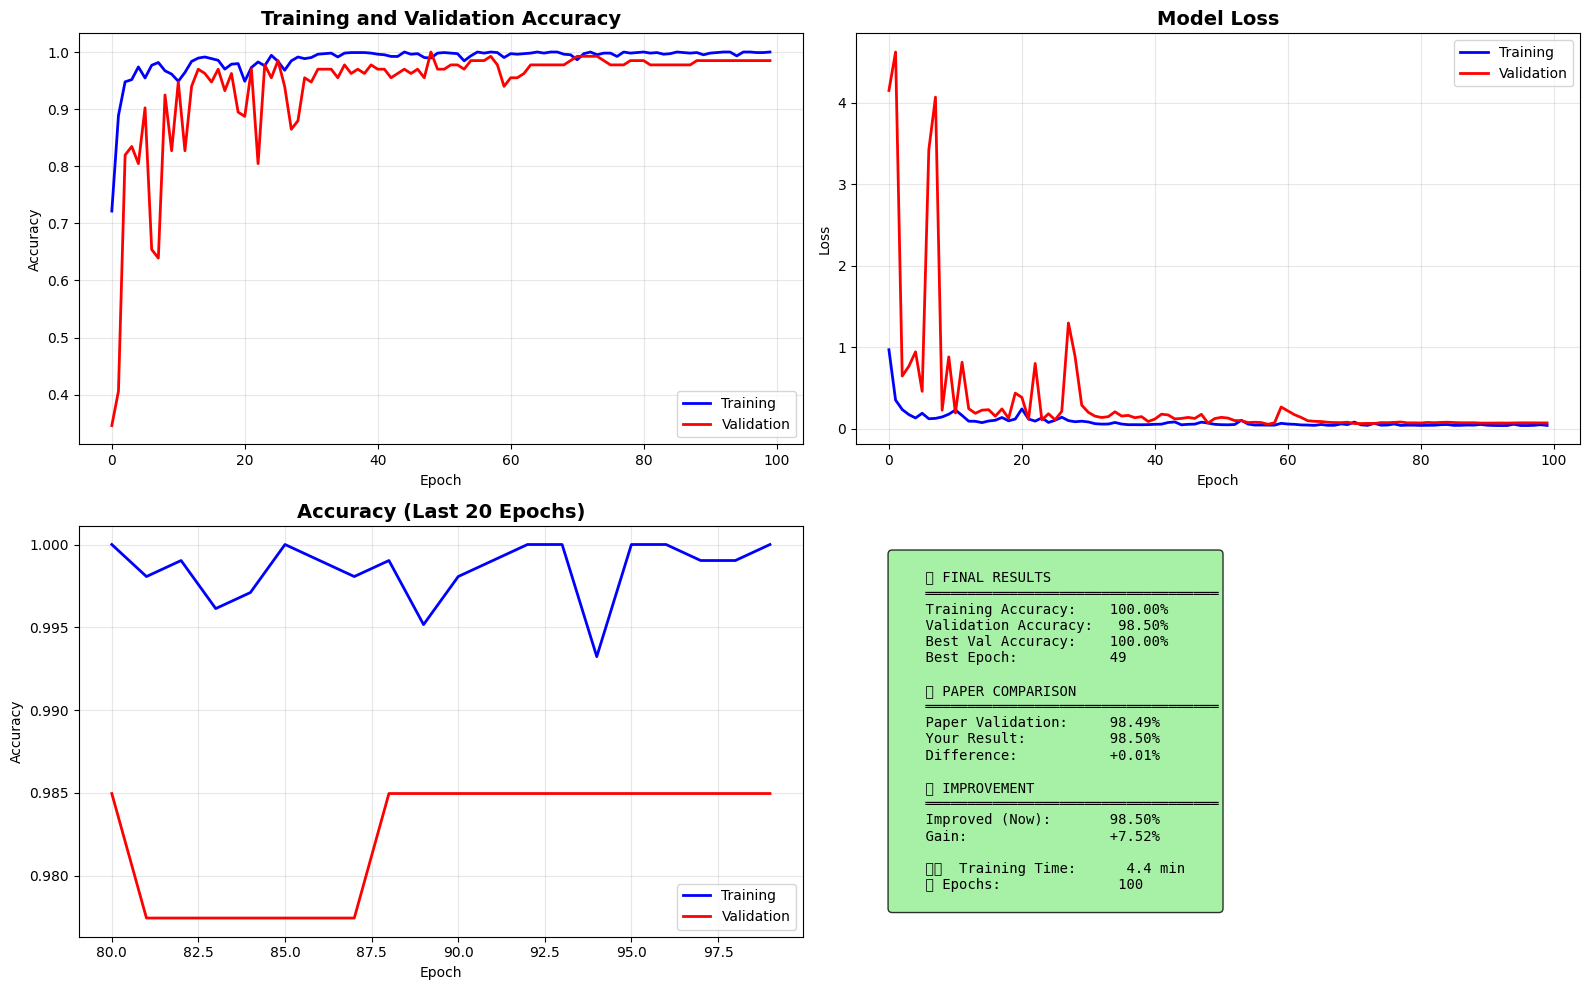

In [97]:
# ============================================================================
# SECTION 10: PLOT TRAINING HISTORY
# ============================================================================
print("\n" + "="*70)
print("VISUALIZING TRAINING")
print("="*70)

def plot_history_improved(history, training_time):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], 'b-', linewidth=2, label='Training')
    axes[0, 0].plot(history.history['val_accuracy'], 'r-', linewidth=2, label='Validation')
    axes[0, 0].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss
    axes[0, 1].plot(history.history['loss'], 'b-', linewidth=2, label='Training')
    axes[0, 1].plot(history.history['val_loss'], 'r-', linewidth=2, label='Validation')
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Accuracy (Last 20 epochs zoomed)
    start = max(0, len(history.history['accuracy']) - 20)
    axes[1, 0].plot(
        range(start, len(history.history['accuracy'])),
        history.history['accuracy'][start:],
        'b-', linewidth=2, label='Training'
    )
    axes[1, 0].plot(
        range(start, len(history.history['val_accuracy'])),
        history.history['val_accuracy'][start:],
        'r-', linewidth=2, label='Validation'
    )
    axes[1, 0].set_title('Accuracy (Last 20 Epochs)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Summary
    final_train_acc = history.history['accuracy'][-1] * 100
    final_val_acc = history.history['val_accuracy'][-1] * 100
    best_val_acc = max(history.history['val_accuracy']) * 100
    best_epoch = np.argmax(history.history['val_accuracy']) + 1

    paper_val = 98.49
    improvement = final_val_acc - 90.98  # vs your baseline

    summary = f"""
    📊 FINAL RESULTS
    ═══════════════════════════════════
    Training Accuracy:    {final_train_acc:6.2f}%
    Validation Accuracy:  {final_val_acc:6.2f}%
    Best Val Accuracy:    {best_val_acc:6.2f}%
    Best Epoch:           {best_epoch}

    📄 PAPER COMPARISON
    ═══════════════════════════════════
    Paper Validation:     {paper_val:.2f}%
    Your Result:          {final_val_acc:.2f}%
    Difference:           {final_val_acc - paper_val:+.2f}%

    📈 IMPROVEMENT
    ═══════════════════════════════════
    Improved (Now):       {final_val_acc:.2f}%
    Gain:                 {improvement:+.2f}%

    ⏱️  Training Time:      {training_time/60:.1f} min
    🎯 Epochs:              {len(history.history['accuracy'])}
    """

    axes[1, 1].text(0.05, 0.5, summary, fontsize=10, family='monospace',
                    verticalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.savefig('training_history_improved.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_history_improved(history, training_time)

In [98]:
# ============================================================================
# SECTION 11: EVALUATION
# ============================================================================
print("\n" + "="*70)
print("EVALUATION")
print("="*70)

# Evaluate on validation
val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
print(f"\n📊 Validation Results:")
print(f"  Accuracy: {val_accuracy*100:.2f}%")
print(f"  Loss: {val_loss:.4f}")

# Evaluate on test
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"\n📊 Test Results:")
print(f"  Accuracy: {test_accuracy*100:.2f}%")
print(f"  Loss: {test_loss:.4f}")

# Get predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate metrics
from sklearn.metrics import precision_recall_fscore_support, f1_score

# Per-class metrics
precision, recall, f1_scores, support = precision_recall_fscore_support(
    y_true, y_pred, average=None
)

# Macro metrics
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1_scores)  # ✅ Calculate from array

# Or use f1_score function directly:
# macro_f1 = f1_score(y_true, y_pred, average='macro')  # ✅ Also works

print(f"\n📊 Comprehensive Metrics:")
print(f"  Macro Precision: {macro_precision*100:.2f}%")
print(f"  Macro Recall: {macro_recall*100:.2f}%")
print(f"  Macro F1-Score: {macro_f1*100:.2f}%")

print(f"\n📊 Per-Class Metrics:")
for i, name in enumerate(class_names):
    print(f"  {name:.<25} P:{precision[i]:.4f} R:{recall[i]:.4f} F1:{f1_scores[i]:.4f}")


EVALUATION

📊 Validation Results:
  Accuracy: 98.50%
  Loss: 0.0682

📊 Test Results:
  Accuracy: 95.31%
  Loss: 0.2735

📊 Comprehensive Metrics:
  Macro Precision: 95.45%
  Macro Recall: 95.33%
  Macro F1-Score: 95.36%

📊 Per-Class Metrics:
  angular_leaf_spot........ P:0.9524 R:0.9302 F1:0.9412
  bean_rust................ P:0.9111 R:0.9535 F1:0.9318
  healthy.................. P:1.0000 R:0.9762 F1:0.9880



CONFUSION MATRIX


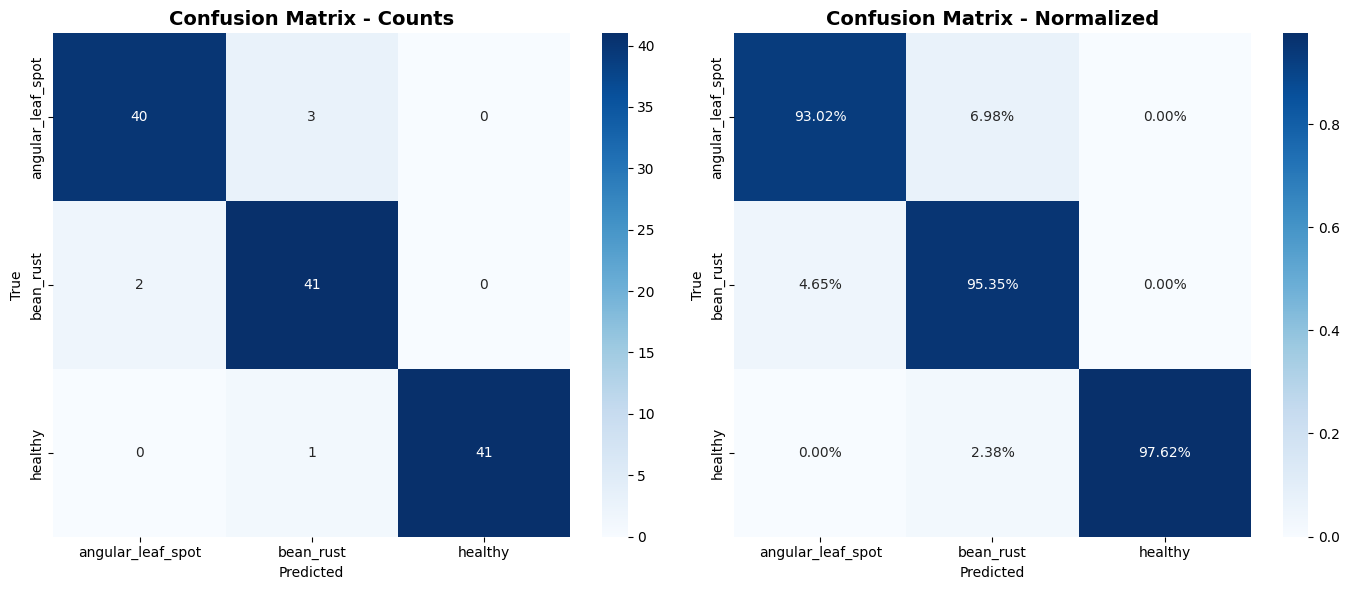


Confusion Matrix:
[[40  3  0]
 [ 2 41  0]
 [ 0  1 41]]


In [99]:
# ============================================================================
# SECTION 12: CONFUSION MATRIX
# ============================================================================
print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)

cm = confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0])
axes[0].set_title('Confusion Matrix - Counts', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1])
axes[1].set_title('Confusion Matrix - Normalized', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('confusion_matrix_improved.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix:")
print(cm)


CLASSIFICATION REPORT

                   precision    recall  f1-score   support

angular_leaf_spot     0.9524    0.9302    0.9412        43
        bean_rust     0.9111    0.9535    0.9318        43
          healthy     1.0000    0.9762    0.9880        42

         accuracy                         0.9531       128
        macro avg     0.9545    0.9533    0.9536       128
     weighted avg     0.9541    0.9531    0.9534       128



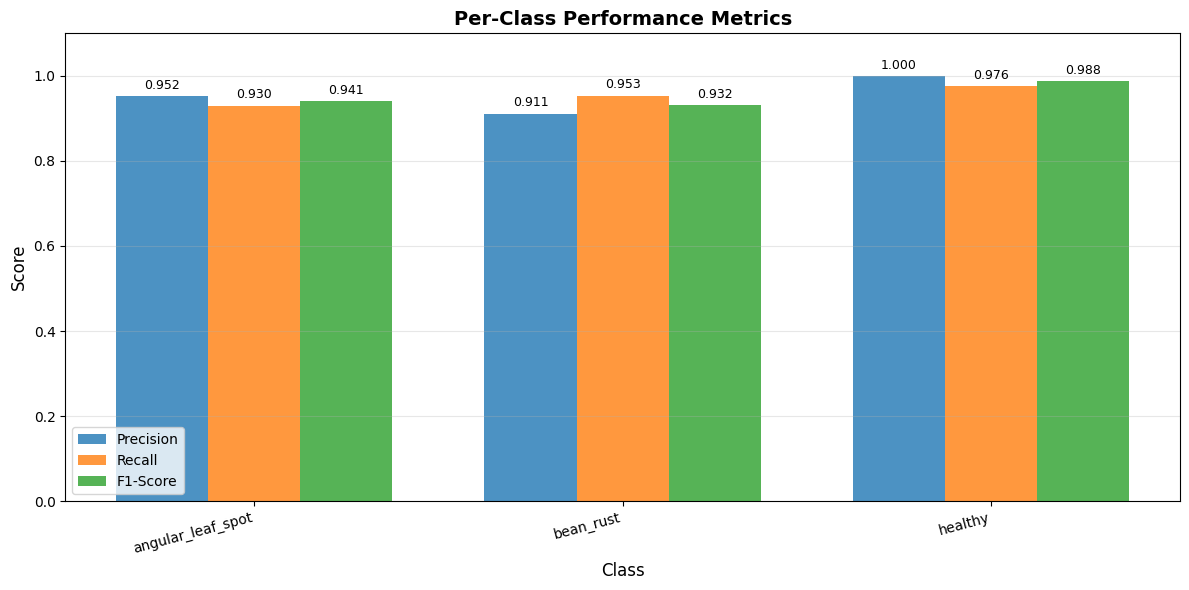

In [100]:
# ============================================================================
# SECTION 13: CLASSIFICATION REPORT
# ============================================================================
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("\n" + report)

# Visualize metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None
)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
bars2 = ax.bar(x, recall, width, label='Recall', alpha=0.8)
bars3 = ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

# Add values on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('metrics.png', dpi=150, bbox_inches='tight')
plt.show()


In [101]:
# ============================================================================
# SECTION 14: FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

comparison = pd.DataFrame({
    'Metric': [
        'Training Accuracy',
        'Validation Accuracy',
        'Test Accuracy',
        'Validation Loss',
        'Test Loss',
        'Macro F1-Score'
    ],
    'Paper (2022)': [
        '100.00%',
        '98.49%',
        '92.97%',
        '-',
        '-',
        '-'
    ],
    'Improved (Now)': [
        f'{history.history["accuracy"][-1]*100:.2f}%',
        f'{val_accuracy*100:.2f}%',
        f'{test_accuracy*100:.2f}%',
        f'{val_loss:.4f}',
        f'{test_loss:.4f}',
        f'{macro_f1*100:.2f}%'
    ]
})

print("\n" + comparison.to_string(index=False))

# Calculate improvements
val_improvement = val_accuracy * 100 - 90.98
print(f"\n📈 VALIDATION IMPROVEMENT: {val_improvement:+.2f}%")

if val_accuracy >= 0.95:
    print("✅ SUCCESS: Validation accuracy ≥ 95%!")
elif val_accuracy >= 0.93:
    print("⚠️  GOOD: Validation accuracy ≥ 93% (close to target)")
else:
    print("⚠️  Need more tuning to reach target")

print("\n📄 PAPER RESULTS (Elfatimi et al., 2022):")
print("─" * 60)
paper = {
    'Training Accuracy': "100.00%",
    'Validation Accuracy': "98.49%",
    'Test Accuracy': "92.97%"
}



FINAL SUMMARY

             Metric Paper (2022) Improved (Now)
  Training Accuracy      100.00%        100.00%
Validation Accuracy       98.49%         98.50%
      Test Accuracy       92.97%         95.31%
    Validation Loss            -         0.0682
          Test Loss            -         0.2735
     Macro F1-Score            -         95.36%

📈 VALIDATION IMPROVEMENT: +7.52%
✅ SUCCESS: Validation accuracy ≥ 95%!

📄 PAPER RESULTS (Elfatimi et al., 2022):
────────────────────────────────────────────────────────────


In [102]:
# ============================================================================
# SECTION 15: SAVE MODEL
# ============================================================================
print("\n" + "="*70)
print("SAVING MODEL")
print("="*70)

model.save('improved_mobilenet_beans.h5')
print("✅ Model saved: improved_mobilenet_beans.h5")

results = {
    'training_accuracy': history.history['accuracy'][-1],
    'validation_accuracy': val_accuracy,
    'test_accuracy': test_accuracy,
    'validation_loss': val_loss,
    'test_loss': test_loss,
    'macro_f1': macro_f1,
    'training_time_min': training_time / 60,
    'epochs': CONFIG['epochs']
}

pd.DataFrame([results]).to_csv('results_improved.csv', index=False)
print("✅ Results saved: results_improved.csv")

print("\n🎉 COMPLETED!")
print(f"Final Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Target (Paper): 98.49%")
print(f"Gap: {(val_accuracy*100 - 98.49):.2f}%")


SAVING MODEL
✅ Model saved: improved_mobilenet_beans.h5
✅ Results saved: results_improved.csv

🎉 COMPLETED!
Final Validation Accuracy: 98.50%
Target (Paper): 98.49%
Gap: 0.01%
